In [1]:
import torch
import torch.nn as nn
import torchvision
from model_file import *
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

In [2]:
model = getModel("vgg16_bn")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 80.2MB/s]


In [3]:
allDL_train = getAllDataLoader(image_size=(224,224), 
                               path_to_dataset="/kaggle/input/vce-dataset/training", batch_size=32)
allDL_val = getAllDataLoader(image_size=(224,224), 
                               path_to_dataset="/kaggle/input/vce-dataset/validation", batch_size=32)

In [4]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

In [5]:
checkpt_path = kagglehub.model_download('bhuvaneshsingla/binaryvce/PyTorch/vgg-binary/1', path='VGGBinary10.pt')
checkpoint = torch.load(checkpt_path)

/tmp/ipykernel_22/2261991416.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpt_path)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [8]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [10]:
# model

In [11]:
model.classifier[6] = nn.Linear(num_ftrs, 10)

In [12]:
model = model.to(device)

In [13]:
num_epochs = 10

In [14]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    
    for inputs, labels in allDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in allDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10]
Train Loss: 1.3473, Train Accuracy: 0.4963
Validation Loss: 1.1843, Validation Accuracy: 0.5597
Epoch [2/10]
Train Loss: 1.0062, Train Accuracy: 0.6265
Validation Loss: 0.9926, Validation Accuracy: 0.6407
Epoch [3/10]
Train Loss: 0.8497, Train Accuracy: 0.6864
Validation Loss: 0.9238, Validation Accuracy: 0.6693
Epoch [4/10]
Train Loss: 0.7238, Train Accuracy: 0.7391
Validation Loss: 0.9083, Validation Accuracy: 0.6963
Epoch [5/10]
Train Loss: 0.6415, Train Accuracy: 0.7738
Validation Loss: 0.9652, Validation Accuracy: 0.6946
Epoch [6/10]
Train Loss: 0.5589, Train Accuracy: 0.8030
Validation Loss: 0.8936, Validation Accuracy: 0.7147
Epoch [7/10]
Train Loss: 0.4797, Train Accuracy: 0.8326
Validation Loss: 1.0288, Validation Accuracy: 0.6925
Epoch [8/10]
Train Loss: 0.3960, Train Accuracy: 0.8638
Validation Loss: 0.9735, Validation Accuracy: 0.7250
Epoch [9/10]
Train Loss: 0.3441, Train Accuracy: 0.8842
Validation Loss: 1.0238, Validation Accuracy: 0.7300
Epoch [10/10]
Train

In [15]:
PATH = "VGG_All10.pt"
torch.save({
            'epoch': num_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [16]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

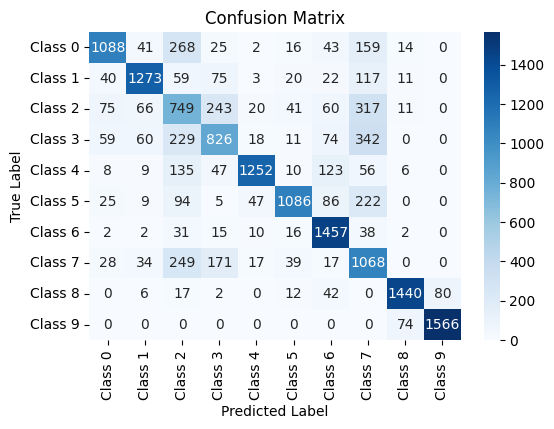

In [17]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, allDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(10)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()